# Kako narediti zglajen pravokoten signal?

Pogosto nas zanima odziv vezja na pravokoten periodični signal. Nastopi pa težava, ko potrebujemo odvod pravokotnega signala. Odvod pravokotne funkcije bi bil povsod 0 razen ob prehodu, kjer pa bi bil odvod neskončen. S takim signalom pa ni mogoče izvajati numeričnih operacij. Niti v praksi odvod pravokotnega signala ne more biti neskončen. Če bi imeli tak tokovni vir priključen na idealno tuljavo, bi se na njej ob prehodu pojavila neskončna napetost, saj velja $u_L(t)=L \frac {di(t)}{dt}$. Zato tedaj, ko potrebujemo odvod pravokotnega signala, moramo le tega preoblikovati tako, da ta odvod ne bo neskončen. Izdelavi in analizi takih signalov je tema tega Jupyter zvezka.


***

## 1. Pravokoten periodičen signal

Pravokoten periodičen signal preprosto naredimo z uporabo SciPy knjižnice. Se pa pojavi problem odvoda. Če odkomentiramo zadnjo vrstico spodnje celice, bo Jupyter vrnil napako. Odvoda te funkcije torej ne moremo narediti.

The slowest run took 5.84 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 143 µs per loop


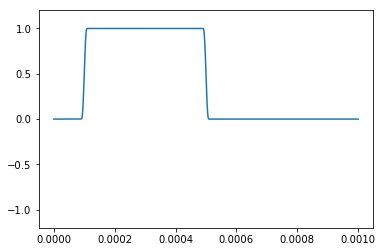

In [423]:
import numpy as np
from scipy import signal

def Signal(t):  # vzbujalni signal kot funkcija. Nato rabim še Ugt - vzbujalni signal kot niz (glej spodaj)
    return signal.square(omega* t) #+ Ug

ts=np.linspace(0,1e-3,1000)
omega=20/max(ts)
y=Signal(ts)
plt.plot(ts,y )
plt.ylim(-1.2, 1.2)
#dy=diff(y)

***
## 2. H funkcija
Ideja je iz http://hplgit.github.io/primer.html/doc/pub/funcif/._funcif-bootstrap004.htmlm, kjer je opisan primer naslednje funkcije, ki omogoči zvezen prehod iz 0 v 1.

\begin{equation}
H_{\epsilon}(x) = \left\lbrace
\begin{array}{ll}
0, &  x < -\epsilon,\\ 
\frac{1}{2} + {x\over 2\epsilon} + {1\over 2\pi}\sin\left(\pi x\over\epsilon\right), & -\epsilon \leq x \leq \epsilon\\ 
1, & x > \epsilon
\end{array}\right.
\end{equation}

Funkcija H je napisana tako, da omogoča realizacijo pravokotnega signala doložine $width$, s periodo $w_{single}$ in številom period $n_{repeat}$. s parametrom $eps$ se določa strmino prehoda iz 0 v 1.

Funkcija H sprejme tri parametre, a = začetek stopnice, w = širina stopnice, x je niz vrednosti, v katerih naj se izračuna H. Funkcija vrne niz y, ki vsebuje eno periodo pravokotnega signala. y2 je niz, ki vrne vrednosti signala za $n_{repeat}$ period. 

dH je numeričen odvod funkcije H. dy2 je numeričen odvod za $n_{repeat}$ period. 

In [417]:
import numpy as np
from sympy import *
from IPython.display import *
import matplotlib.pyplot as plt
%matplotlib inline 
init_printing(use_latex=True)

3000


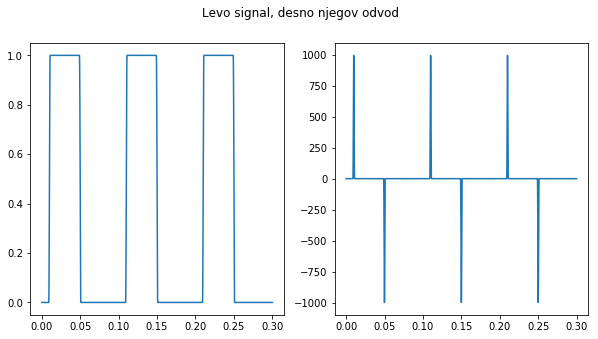

In [425]:
eps=0.001
astart=0.01 # zaćetek stopnice , najmanj eps
width=0.04 # širina stopnice
w_single=0.1 # dolžina ene periode
n_repeat=3  # število period (ponovitev)

def H(a,w,x):
    n=len(x)
    if w < a:
        raise ValueError("w must be larger than a")
    elif a<eps: 
        raise ValueError("a must be larger or equal to eps")
    for i in range(n):
        if x[i]<(-eps+a): y[i]=0
        elif x[i]>(-eps+a) and x[i]<(eps+a): y[i]=(1/2+(x[i]-a)/(2*eps)+np.sin(np.pi*(x[i]-a)/eps)/(2*np.pi))
        elif x[i]>(eps+a) and x[i]<(-eps+a+w): y[i]=1    
        elif x[i]>(-eps+a+w) and x[i]<(eps+a+w): y[i]=1-(1/2+(x[i]-a-w)/(2*eps)+np.sin(np.pi*(x[i]-a-w)/eps)/(2*np.pi))
        else: y[i]=0
        
cas=np.linspace(0,w_single,1000)
dt=cas[1]
y=np.zeros(1000)

H(astart,width,cas)
dy_temp=np.diff(y)/dt
dy=np.append(dy_temp,0)

cas2=np.linspace(0,w_single*n_repeat,1000*n_repeat)
y2=[]
dy2=[]
for i in range(n_repeat):
    y2=np.append(y2,y)
    dy2=np.append(dy2,dy)
print(len(cas2))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Levo signal, desno njegov odvod')
ax1.plot(cas2, y2)
ax2.plot(cas2, dy2)



### Analiza fft H funkcije
Npr. po https://gist.github.com/jedludlow/3919130 


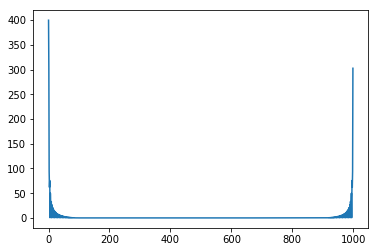

In [419]:
f_s=100/(w_single)  # sampling freq = 50 x osnovna
fft_x = np.fft.fft(y)
n = len(fft_x)
freq = np.fft.fftfreq(n, 1/f_s)
#print(freq)
plt.plot(np.abs(fft_x))

20


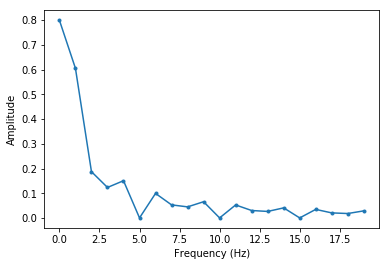

In [420]:
n1 = 20 #int(np.ceil(n/20.0))
print(n1)
fft_x_n1 = (2.0 / n) * fft_x[:n1]
freq_n1 = freq[:n1]

plt.plot(freq_n1, np.abs(fft_x_n1),'.-')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

### Naredim še integracijo odvoda, da vidim, če dobro rekonstruira signal
Integral odvoda funkcije mora namreč dati nazaj prvotno funkcijo.To tudi dejansko dobimo.

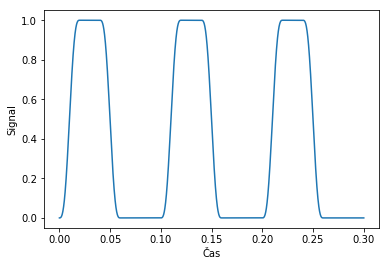

In [421]:
yint2=np.cumsum(dy2)

plt.plot(cas2, yint)
plt.xlabel('Čas')
plt.ylabel('Signal')
plt.show()

### Naredimo še zapis signala in odvoda v obliki funcije, ki vrača le vrednost v točki

Odvod je analitično izračunan in vstavljen v funkcijo dH1.
Odvod je izračunan kot 
$dH(x)=\frac{1}{2 \epsilon}(1+\cos(\frac{\pi x}{\epsilon}))  $ torej

\begin{equation}
dH_{\epsilon}(x) = \left\lbrace
\begin{array}{ll}
0, &  x < -\epsilon,\\ 
\frac{1}{2 \epsilon}\left(1 + \cos\left(\pi x\over\epsilon\right) \right), & -\epsilon \leq x \leq \epsilon\\ 
1, & x > \epsilon
\end{array}\right.
\end{equation}

Velikost odvoda bo očitno odvisna od parametra $eps$. Pri manjšem parametru $eps$ bo odvod večji. 

10 loops, best of 3: 91 ms per loop


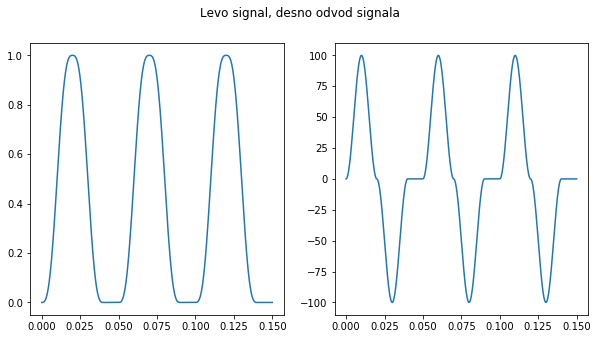

In [429]:
eps=0.01  # funkcija se zvezno spreminja od 0 do 1 znotraj območja 2*eps
astart=0.01 # zaćetek stopnice , najmanj eps
width=0.02 # širina stopnice
w_single=0.05 # dolžina ene periode
n_repeat=3


def H1(a,w,x):
    if x>w_single:
            x=x-np.fix(x/w_single)*w_single
    if x<(-eps+a): return 0
    elif x>(-eps+a) and x<(eps+a): return (1/2+(x-a)/(2*eps)+np.sin(np.pi*(x-a)/eps)/(2*np.pi))
    elif x>(eps+a) and x<(-eps+a+w): return 1    
    elif x>(-eps+a+w) and x<(eps+a+w): return 1-(1/2+(x-a-w)/(2*eps)+np.sin(np.pi*(x-a-w)/eps)/(2*np.pi))
    else: return 0

def dH1(a,w,x):  
    if x>w_single:
            x=x-np.fix(x/w_single)*w_single
    if x<(-eps+a): return 0
    elif x>(-eps+a) and x<(eps+a): return (1/(2*eps)+np.cos(np.pi*(x-a)/eps)/(2*eps))
    elif x>(eps+a) and x<(-eps+a+w): return 0    
    elif x>(-eps+a+w) and x<(eps+a+w): return -(1/(2*eps)+np.cos(np.pi*(x-a-w)/eps)/(2*eps))
    else: return 0



    
cas=np.linspace(0,w_single*n_repeat,2000)

y=np.zeros(2000)
dy=np.zeros(2000)

def test():
    for i in range(len(cas)):
        y[i]=H1(astart,width,cas[i])
        dy[i]=dH1(astart,width,cas[i])                                                 
    
test()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Levo signal, desno odvod signala')
ax1.plot(cas, y)
ax2.plot(cas, dy)



\begin{equation}
H_{\epsilon}(x) = \left\lbrace
\begin{array}{ll}
0, &  x < -\epsilon,\\ 
\frac{1}{2} + {x\over 2\epsilon} + {1\over 2\pi}\sin\left(\pi x\over\epsilon\right), & -\epsilon \leq x \leq \epsilon\\ 
1, & x > \epsilon
\end{array}\right.
\tag{}
\end{equation}

***
## 3. Pravokoten periodični signal tvorjen s Fourierovo vrsto

Pravokotni signal naredimo s pomočjo Fourierove vrste,glej npr.

http://mathworld.wolfram.com/FourierSeriesSquareWave.html

\begin{equation}
f(x)= \frac{4}{\pi} \sum_{n=1,3,5}^{\infty} \frac{1}{n} \sin  (\frac{n\pi x}{L} )
\end{equation}    

V konkretnem primeru smo vzeli n =1,3, .. 199. Spreminjaj n v drugi vrstici in glej rezultat.

In [431]:
t = np.linspace(-np.pi, np.pi, 201) # t=pi*x
n = np.arange(1, 100)
n = 2 * n - 1  # liha števila
f = np.zeros_like(t)

In [434]:
def test():
    for i, ti in enumerate(t):
       f[i] = np.sum(np.sin(n * ti)/n)

f = (4 / np.pi) * f
test()

dt=t[1]-t[0]
df_temp=np.diff(f)/dt


df=np.append(df_temp,0)

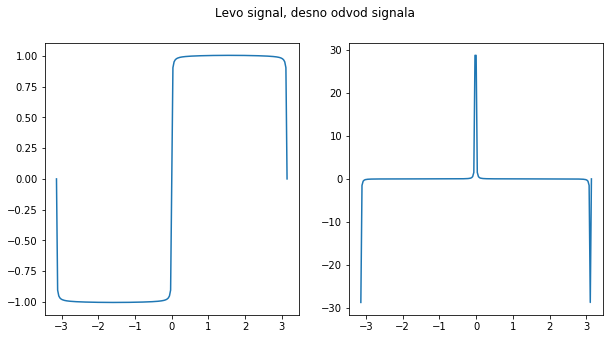

In [409]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Levo signal, desno odvod signala')
ax1.plot(t, f)
ax2.plot(t, df)



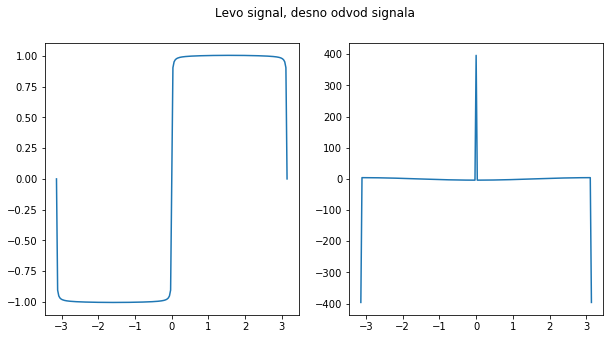

In [410]:
df2 = np.zeros_like(t)
for i, ti in enumerate(t):
   df2[i] = np.sum(np.cos(k * ti))

df2 = (4 ) * df2

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Levo signal, desno odvod signala')
ax1.plot(t, f)
ax2.plot(t, df2)

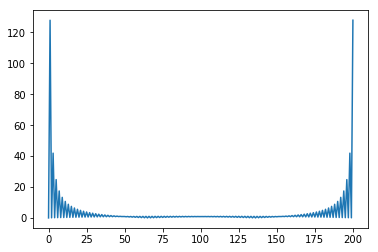

In [350]:
f_s=100/(np.pi)  # sampling freq = 50 x osnovna
fft_x = np.fft.fft(f)
n = len(fft_x)
freq = np.fft.fftfreq(n, 1/f_s)
#print(freq)
plt.plot(np.abs(fft_x))



101


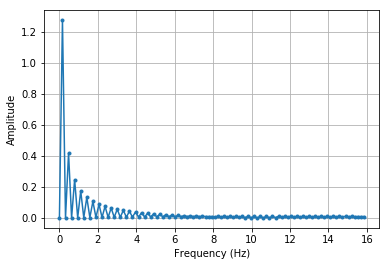

In [349]:
n1 = int(np.ceil(n/2.0))
print(n1)
fft_x_n1 = (2.0 / n) * fft_x[:n1]
freq_n1 = freq[:n1]


plt.plot(freq_n1, np.abs(fft_x_n1),'.-')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()

In [348]:
print(freq_n1,abs(fft_x_n1))

[ 0.          0.15836313  0.31672625  0.47508938  0.63345251  0.79181564
  0.95017876  1.10854189  1.26690502  1.42526815  1.58363127] [  5.44616867e-16   1.27291850e+00   6.76967709e-04   4.17045194e-01
   1.19790455e-03   2.46699323e-01   1.70096583e-03   1.73384465e-01
   2.18143173e-03   1.32425388e-01   2.64247785e-03]


***
## 4. Tretja varianta / sigmunoidna funkcija

Poglejmo še eno varianto (po https://kitchingroup.cheme.cmu.edu/pycse/pycse.html), signunoidno funkcijo:

\begin{equation}
\sigma(x) = \frac{1}{1 + e^{-(x-x0)/\alpha}}$
\end{equation}



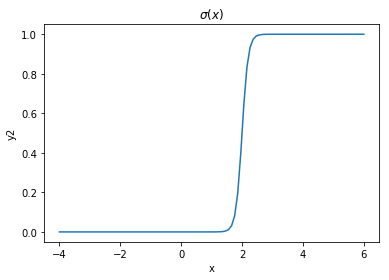

In [412]:
alfa=0.1
x0=2
x = np.linspace(-4, 6,100);
y = 1.0 / (1 + np.exp(-(x-x0) / alfa))
y2=1-1.0 / (1 + np.exp(-(x-x0) / alfa))
plt.figure(2)
plt.clf()
plt.plot(x, y)
plt.xlabel('x'); plt.ylabel('y2'); plt.title('$\sigma(x)$')
# plt.savefig('images/smooth-transitions-sigma.png')

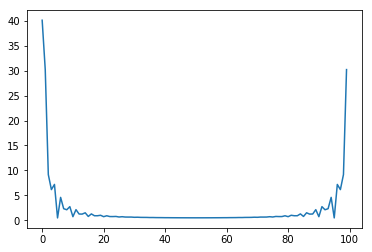

In [413]:
f_s=100/(np.pi)  # sampling freq = 50 x osnovna
fft_x = np.fft.fft(y)
n = len(fft_x)
freq = np.fft.fftfreq(n, 1/f_s)
#print(freq)
plt.plot(np.abs(fft_x))


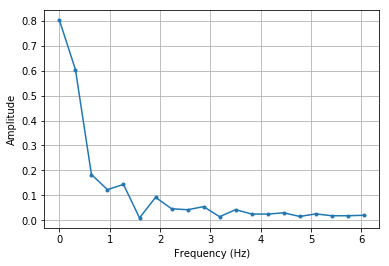

In [414]:
n1 = 20
fft_x_n1 = (2.0 / n) * fft_x[:n1]
freq_n1 = freq[:n1]
plt.plot(freq_n1, np.abs(fft_x_n1),'.-')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()